# Collaborative Filtering Recommendation System
## Hyun Ko, Eric Tria, Chunru Zheng

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics.pairwise import cosine_similarity

## Step 1: Preparing Data

Data is from the [Netflix Prize Data](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data) Kaggle dataset.

Make sure to download all the files from Kaggle before running all the cells.

In [ ]:
start_count = [1, 4500, 9211, 13368]
end_count = [4499, 9210, 13367, 17770]

In [ ]:
def whole_processor(file_num):
  filename = f"combined_data_{file_num}.txt"
  df = pd.read_csv(filename, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
  df['Rating'] = df['Rating'].astype(float)

  movie_idx = df[df['Rating'].isnull()].index

  empty_list = []
  df['Movie_Number'] = np.append(empty_list, np.repeat(np.nan, len(df)))

  timeA = time.time()
  movie_count = start_count[file_num-1]
  tmp_list = []
  for i in range(len(movie_idx)-1):
    start_idx = movie_idx[i]
    end_idx = movie_idx[i+1]
    df.loc[start_idx:end_idx,'Movie_Number'] = np.repeat(movie_count, end_idx - start_idx + 1)
    movie_count += 1

  df.loc[movie_idx[-1]:,'Movie_Number'] = end_count[file_num-1]

  final_df = df[df['Rating'].notna()]
  save_filename = f"{start_count[file_num-1]}_to_{end_count[file_num-1]}.csv"
  final_df.to_csv(save_filename,index=False)
  timeB = time.time()
  print("Running time:", (timeB - timeA) / 60)
  return final_df

In [ ]:
df1 = pd.read_csv('0_to_4499.csv')
df2 = pd.read_csv('4500_to_9210.csv')
df3 = pd.read_csv('9211_to_13367.csv')
df4 = pd.read_csv('13368_to_17770.csv')

In [ ]:
all_df = pd.concat([df1,df2,df3,df4])
all_df

,Cust_Id,Rating,Movie_Number
0,1488844,3.0,1.0
1,822109,5.0,1.0
2,885013,4.0,1.0
3,30878,4.0,1.0
4,823519,3.0,1.0
...,...,...,...
26847518,1790158,4.0,17770.0
26847519,1608708,3.0,17770.0
26847520,234275,1.0,17770.0
26847521,255278,4.0,17770.0


## Step 2: Subsetting Data

In [ ]:
# Code from https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
# Extract Top 500 popular movies

f = ['count','mean']

df_movie_summary = all_df.groupby('Movie_Number')['Rating'].agg(f).sort_values(by=['count'], ascending = False)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = df_movie_summary['count'][:500].min()
movie_benchmark
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 37995


In [ ]:
# Extract Top 1000 Ardent Users

df_cust_summary = all_df.groupby('Cust_Id')['Rating'].agg(f).sort_values(by=['count'], ascending = False)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = df_cust_summary['count'][:1000].min() #round(df_cust_summary['count'].quantile(0.995),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 2087


In [ ]:
rating_df = df.pivot_table(index=['Cust_Id'], columns='Movie_Number', values='Rating')
rating_df = pd.DataFrame(rating_df.to_records())
rating_df

,Cust_Id,28.0,30.0,143.0,175.0,191.0,197.0,241.0,290.0,299.0,...,17479.0,17482.0,17506.0,17508.0,17560.0,17621.0,17622.0,17627.0,17709.0,17764.0
0,1333,2.0,3.0,4.0,3.0,1.0,2.0,3.0,4.0,1.0,...,2.0,2.0,NaN,1.0,NaN,NaN,3.0,2.0,3.0,4.0
1,3321,4.0,5.0,3.0,NaN,4.0,NaN,NaN,4.0,4.0,...,4.0,4.0,2.0,NaN,4.0,NaN,2.0,4.0,4.0,5.0
2,3998,5.0,5.0,4.0,NaN,5.0,5.0,5.0,5.0,5.0,...,5.0,4.0,NaN,NaN,5.0,4.0,5.0,5.0,NaN,5.0
3,5980,NaN,5.0,3.0,3.0,NaN,NaN,NaN,5.0,NaN,...,5.0,NaN,5.0,5.0,3.0,NaN,4.0,5.0,NaN,5.0
4,10268,NaN,3.0,4.0,4.0,4.0,4.0,3.0,NaN,3.0,...,3.0,NaN,NaN,3.0,4.0,4.0,4.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2637886,5.0,5.0,5.0,2.0,4.0,NaN,NaN,5.0,5.0,...,3.0,3.0,NaN,4.0,5.0,3.0,2.0,5.0,5.0,5.0
997,2640278,3.0,NaN,4.0,5.0,5.0,NaN,NaN,5.0,NaN,...,3.0,NaN,NaN,4.0,4.0,4.0,4.0,NaN,3.0,3.0
998,2640550,4.0,5.0,4.0,2.0,4.0,5.0,NaN,4.0,5.0,...,4.0,3.0,5.0,NaN,3.0,NaN,3.0,5.0,4.0,4.0
999,2640760,3.0,3.0,4.0,5.0,4.0,NaN,5.0,4.0,3.0,...,4.0,4.0,NaN,4.0,4.0,4.0,NaN,4.0,NaN,3.0


In [15]:
titles = pd.read_csv("movie_titles.csv", encoding = "unicode_escape", header = None).iloc[:,:3]
titles.columns = ["ID","year", "title"]
# titles

In [ ]:
raw_titles = [titles[titles["ID"] == float(movie_id)]["title"].values[0] for movie_id in rating_df.columns[1:]]
rating_df.columns = ["Cust_ID"] + raw_titles
# rating_df

In [ ]:
rating_df.to_csv('unscaled_title_data.csv', index = 0)

## Step 3: Scaling

In [5]:
rating_df = pd.read_csv('unscaled_title_data.csv')

In [7]:
scaled_df = rating_df.copy().iloc[:,1:]
averages = scaled_df.mean(axis=1).values
for i in range(len(rating_df)):
  # Subtract by mean of each user, not the entire user
  scaled_df.iloc[i,:] = (scaled_df.iloc[i,:] - averages[i]) 

scaled_df = scaled_df.fillna(0) # fillna(0) should come after scaling
scaled_df["Cust_Id"] = rating_df["Cust_Id"]
scaled_df = pd.concat([pd.DataFrame({"Cust_Id": scaled_df["Cust_Id"]}), scaled_df.iloc[:,1:]], axis = 1)
scaled_df

,Cust_Id,The Wedding Planner,Pirates of the Caribbean: The Curse of the Black Pearl,50 First Dates,What Women Want,The Bourne Supremacy,Lord of the Rings: The Fellowship of the Ring,Braveheart,Ghost,Men in Black II,...,The Day After Tomorrow,Sweet Home Alabama,Con Air,The Green Mile,The Fugitive,Titanic,Indiana Jones and the Last Crusade,National Treasure,The Terminal,Cust_Id
0,1333,0.000000,-1.014750,-0.014750,-0.014750,-0.014750,1.985250,0.985250,-1.014750,-2.014750,...,0.985250,-1.014750,-2.014750,-0.014750,-0.014750,0.985250,-0.014750,-0.014750,0.985250,1333
1,3321,0.000000,-0.175226,-0.175226,-0.175226,-1.175226,0.824774,0.824774,-0.175226,-0.175226,...,0.000000,0.000000,-0.175226,0.824774,-0.175226,-0.175226,0.824774,-0.175226,-0.175226,3321
2,10268,-0.882240,-0.882240,0.000000,0.117760,0.117760,0.117760,0.117760,-0.882240,-0.882240,...,0.117760,-0.882240,0.117760,1.117760,0.117760,0.117760,0.117760,0.117760,0.117760,10268
3,10374,-1.708605,0.291395,-0.708605,-0.708605,0.291395,0.291395,0.291395,0.291395,0.291395,...,0.291395,0.291395,-0.708605,0.291395,0.291395,0.291395,0.291395,0.291395,0.291395,10374
4,11043,0.637527,0.637527,0.637527,0.637527,-0.362473,-0.362473,0.637527,-0.362473,-0.362473,...,-0.362473,0.637527,0.637527,0.637527,0.637527,0.637527,-0.362473,0.637527,-0.362473,11043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2625420,0.000000,0.000000,0.000000,0.000000,1.518172,1.518172,0.518172,0.000000,-1.481828,...,0.518172,0.000000,0.000000,0.000000,-0.481828,0.518172,0.000000,0.000000,0.000000,2625420
496,2626336,-2.989698,1.010302,-0.989698,0.010302,-1.989698,1.010302,1.010302,0.010302,-0.989698,...,-0.989698,-1.989698,-0.989698,1.010302,1.010302,1.010302,0.010302,0.010302,0.010302,2626336
497,2630337,-3.191521,0.808479,0.000000,-1.191521,0.808479,0.000000,0.808479,0.808479,0.808479,...,0.808479,0.808479,0.808479,0.808479,0.000000,-0.191521,0.808479,0.808479,0.808479,2630337
498,2634967,-0.415775,0.584225,-0.415775,0.584225,-0.415775,1.584225,0.584225,0.584225,-0.415775,...,-0.415775,-0.415775,-2.415775,1.584225,-1.415775,0.584225,0.584225,0.000000,-0.415775,2634967


## Step 2: Compare Similarities

In [8]:
def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

In [10]:
def return_similarity(current_rating, idx):
    similarity_list = []
    for i in range(len(scaled_df)):
        if i == idx:
            continue
        another_rating = np.array([scaled_df.iloc[i,1:]]) # rating of another user
        curr_similarity = round(cosine_similarity(current_rating, another_rating)[0][0], 3)
        similarity = {
            'user_idx': i,
            'cosine_similarity': curr_similarity
        }
        similarity_list.append(similarity)

    return similarity_list

In [11]:
def plot_rating(expected_dict, idx):
    title = expected_dict.keys()
    rating = expected_dict.values()
    recommended = []
    for score in rating:
        if score > 0:
            recommended.append(True)
        else:
            recommended.append(False)
            
    df = pd.DataFrame({
        "Title": title, 
        "Expected Rating": rating, 
        "Recommended": recommended
    }).sort_values(by = "Expected Rating", ascending = False)
    plt.figure(figsize=(20, 7))
    plt.xticks(rotation=90)
    plt.title("Predicted Rating for Unwatched Movies and Recommendation")
    
    # return the plot and a dataframe of the top 10 recommended movies
    return (sns.barplot(x = "Title", y = "Expected Rating", hue = "Recommended", data = df), df.iloc[:10,:])

In [18]:
movie_titles = scaled_df.columns[1:]

In [32]:
def get_similarity(idx):
    current_rating = np.array([scaled_df.iloc[idx,1:]]) # rating of the current user
  
    # BASE CASE: if the user has watched all movies, then returns nothing.
    if 0 not in current_rating: 
        print("This user has watched all the movies.")
        return -1

    similarity_list = return_similarity(current_rating, idx)

    idx_count = 0
    ratings = current_rating[0].tolist()
    expected_dict = dict()
    
    for movie in movie_titles:
        print('idx', idx)
        print(movie)
        rating = scaled_df[movie].iloc[idx]
        print(rating)
        
        # skip if the user has already seen a movie
        if rating != 0: 
            continue
            
        count = 0
        #movie_idx = indices(ratings, rating)[idx_count] #ratings.index(rating)
        numerator = 0
        denominator = 0

        idx_count += 1

        for j in range(len(scaled_df)):
            # don't add up the user's own rating
            if j == idx: 
                continue
            other_rating = round(scaled_df[movie].iloc[j],3)
            other_similarity = similarity_list[count]
            count += 1
      
            # we do not consider the similarity of unwatched user 
            # because it only affects the denominator but not numerator
            if other_rating == 0: 
                continue

            # numerator is iteratively adding up each rating x each similarity score
            numerator = numerator + (other_rating * other_similarity)
            denominator += other_similarity

        if denominator == 0: # avoid zero division error
            expected_rating = 0
        else:
            expected_rating = round(numerator / denominator, 2)

        expected_dict[movie] = expected_rating

    return plot_rating(expected_dict, idx)

In [33]:
res1 = get_similarity(1)

idx 1
The Wedding Planner
0.0
idx 1
Pirates of the Caribbean: The Curse of the Black Pearl
-0.1752258312512014
idx 1
50 First Dates
-0.1752258312512014
idx 1
What Women Want
-0.1752258312512014
idx 1
The Bourne Supremacy
-1.1752258312512014
idx 1
Lord of the Rings: The Fellowship of the Ring
0.8247741687487986
idx 1
Braveheart
0.8247741687487986
idx 1
Ghost
-0.1752258312512014
idx 1
Men in Black II
-0.1752258312512014
idx 1
The Last Samurai
0.8247741687487986
idx 1
Bruce Almighty
-0.1752258312512014
idx 1
Shrek 2
-0.1752258312512014
idx 1
Finding Nemo (Widescreen)
-0.1752258312512014
idx 1
The Sixth Sense
0.8247741687487986
idx 1
The Italian Job
0.0
idx 1
Beijing Bicycle
-1.6405150874495487
idx 1
Pearl Harbor
0.0
idx 1
Pulp Fiction
-0.1752258312512014
idx 1
Forrest Gump
0.8247741687487986
idx 1
Lord of the Rings: The Two Towers
0.8247741687487986
idx 1
Swordfish
-0.1752258312512014
idx 1
Spider-Man 2
-0.1752258312512014
idx 1
Lost in Translation
0.8247741687487986
idx 1
The Rock
-0.175

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [21]:
res1[1]

,Title,Expected Rating,Recommended
0,The Wedding Planner,-0.83,False


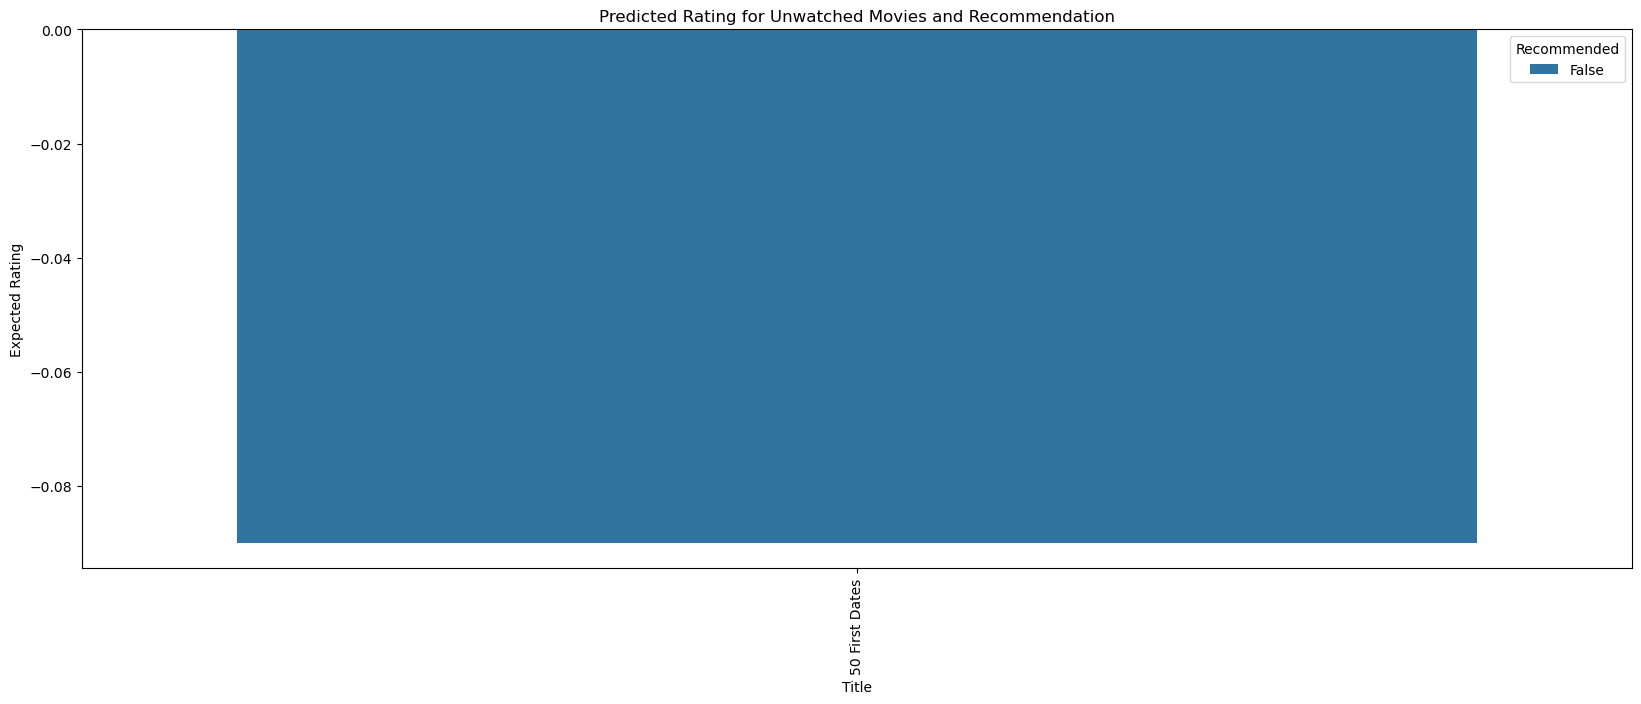

In [22]:
res2 = get_similarity(2)

In [23]:
res2[1]

,Title,Expected Rating,Recommended
0,50 First Dates,-0.09,False


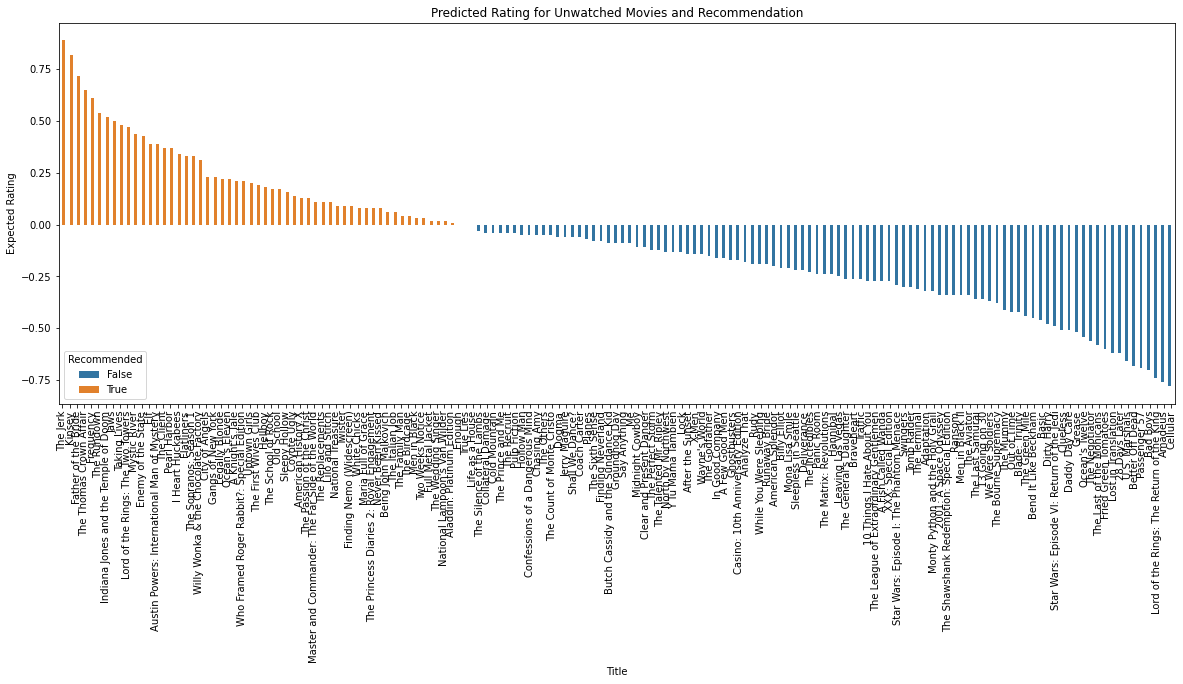

In [ ]:
res3 = get_similarity(175)

In [ ]:
res3[1]

,Title,Expected Rating,Recommended
82,The Jerk,0.89,True
87,Kinsey,0.82,True
131,Father of the Bride,0.72,True
110,The Thomas Crown Affair,0.65,True
77,Frequency,0.61,True
37,The Rundown,0.54,True
79,Indiana Jones and the Temple of Doom,0.52,True
7,Jaws,0.50,True
1,Taking Lives,0.48,True
78,Lord of the Rings: The Two Towers,0.47,True


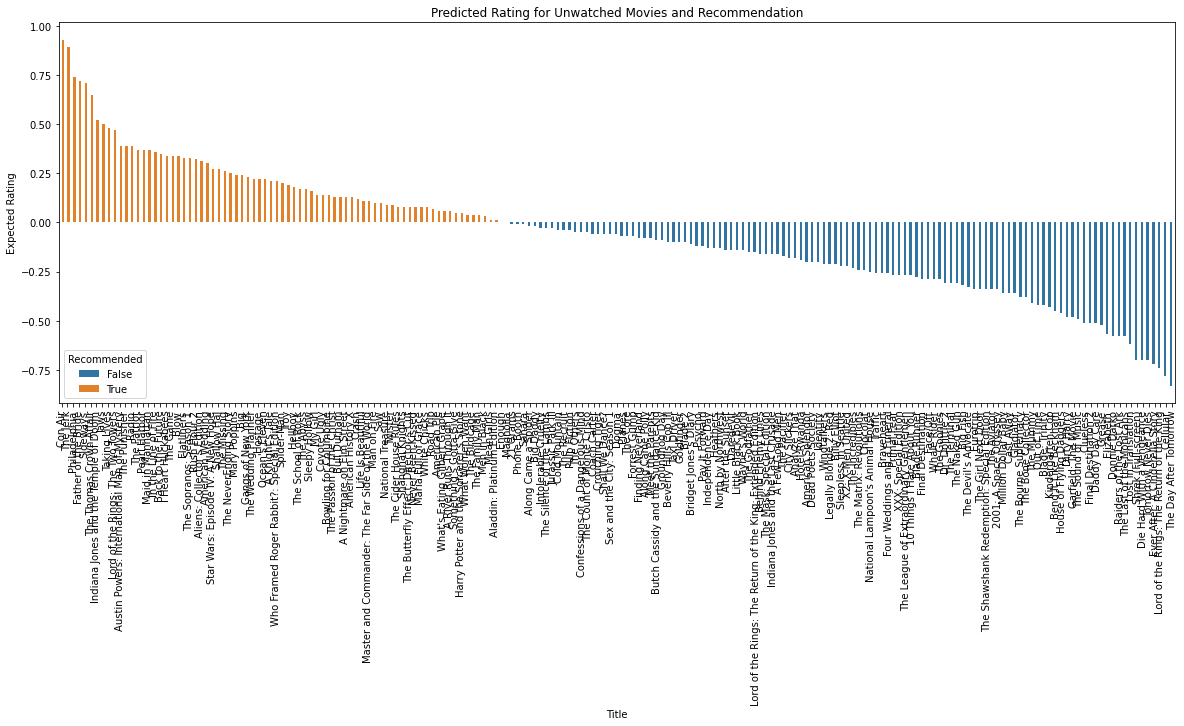

In [ ]:
res4 = get_similarity(440)

In [ ]:
res4[1]

,Title,Expected Rating,Recommended
161,Con Air,0.93,True
101,The Jerk,0.89,True
182,Philadelphia,0.74,True
159,Father of the Bride,0.72,True
41,Sideways,0.71,True
132,The Thomas Crown Affair,0.65,True
94,Indiana Jones and the Temple of Doom,0.52,True
13,Jaws,0.50,True
3,Taking Lives,0.48,True
91,Lord of the Rings: The Two Towers,0.47,True


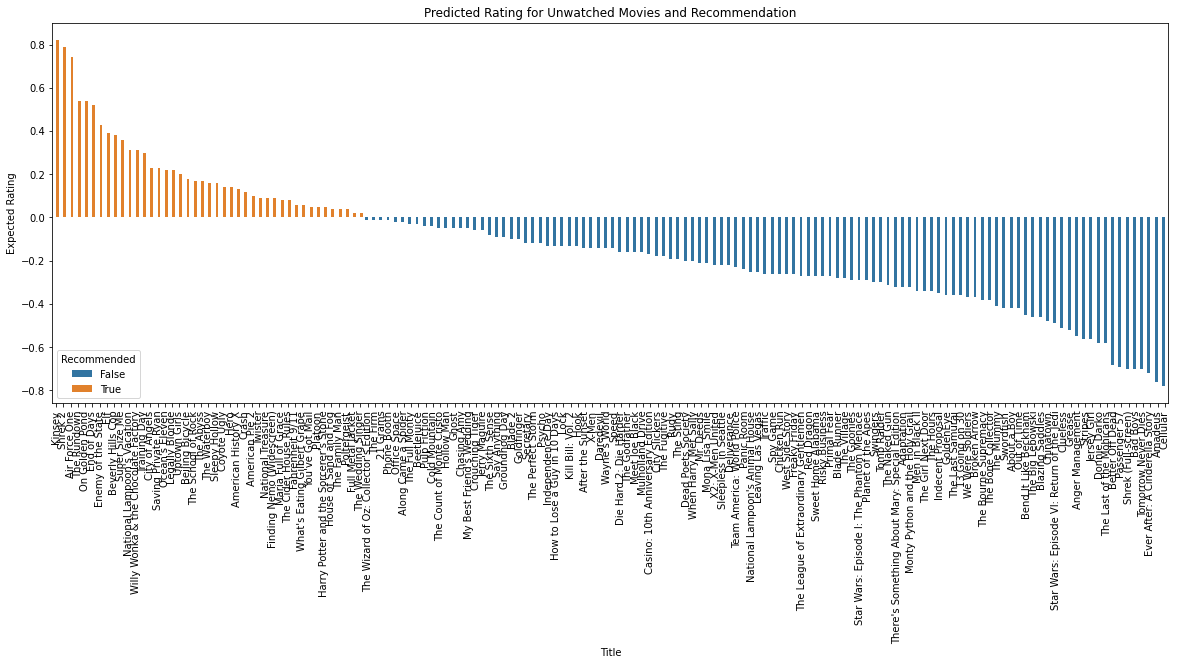

In [ ]:
res5 = get_similarity(999)

In [ ]:
res5[1]

,Title,Expected Rating,Recommended
90,Kinsey,0.82,True
43,Shrek 2,0.79,True
100,Air Force One,0.74,True
30,The Rundown,0.54,True
23,On Golden Pond,0.54,True
42,End of Days,0.52,True
104,Enemy of the State,0.43,True
29,Elf,0.39,True
17,Beverly Hills Cop,0.38,True
24,Super Size Me,0.36,True
